# Wavelet-regularized pixelated source modeling
### Fit the source light as a regularised grid of pixels, assuming a fixed parametric lens (SIE + shear)
The true source is an elliptical Sérsic profile here, but can be anything.

__last updated__: 30/07/21

In [1]:
# Basic imports
from time import time
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# OPTAX
import optax

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util
from jaxtronomy.Util.jax_util import WaveletTransform

# Universal font size
FS = 18

np.random.seed(18)

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [6]:
exp_time = None
sigma_bkd = 0.05
noise_map = sigma_bkd * np.ones((npix, npix))
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Image model

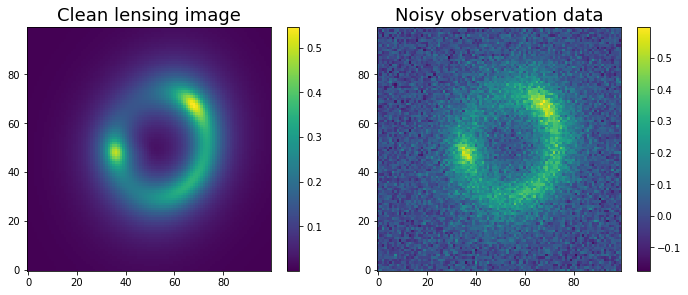

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

# Clean lens image
image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

# True source on data grid
source_true = lens_image.source_surface_brightness(kwargs_source=kwargs_source_light, 
                                                   de_lensed=True, unconvolved=True)

# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_lens_mass,
                              kwargs_source=kwargs_source_light,
                              kwargs_lens_light=kwargs_lens_light)

# 1D coordinate arrays for source grid interpolation
x_coords = lens_image.Grid.pixel_coordinates[0][0, :]
y_coords = lens_image.Grid.pixel_coordinates[1][:, 0]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

_TEST RAY-TRACING_

## Source fitting on a pixelated grid with starlet regularisation

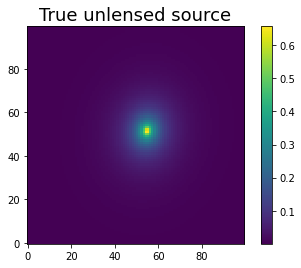

In [8]:
# Visualise the true source
fig, ax = plt.subplots(1, 1)
img = ax.imshow(source_true, origin='lower')
ax.set_title("True unlensed source", fontsize=FS)
fig.colorbar(img)

In [9]:
# # Create a mask
# mask = (jnp.hypot(xgrid, ygrid) <= 3).astype(float)

# fig, ax = plt.subplots(1, 1)
# ax.imshow(data, origin='lower')
# img = ax.imshow(mask, origin='lower', cmap='gray', alpha=0.6)
# ax.set_title("Mask")
# fig.colorbar(img)

### Create a model for fitting

In [10]:
# Recreate a Noise object with true noise map
kwargs_noise_fit = {'background_rms': sigma_bkd, 'noise_map': noise_map}
fit_noise = Noise(npix, npix, **kwargs_noise_fit)

# Change only the source light model
fit_source_light_model_list = ['PIXELATED']
fit_source_light_model = LightModel(fit_source_light_model_list)
fit_lens_image = LensImage(pixel_grid, psf, noise_class=fit_noise,
                             lens_model_class=lens_mass_model,
                             source_model_class=fit_source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

In [11]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': fit_source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{'image': 1e-5*jnp.ones_like(source_true)}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    #'kwargs_source': [{}],
    'kwargs_source': [{'image': ['uniform', 0., 10.]}],
}
kwargs_fixed = {
    'kwargs_lens': kwargs_lens_mass,
    'kwargs_source': [{
        'x_coords': jnp.asarray(x_coords), 
        'y_coords': jnp.asarray(y_coords),
    }],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {
    'kwargs_lens': kwargs_lens_mass, 
    'kwargs_source': [{'image': source_true, 'x_coords': x_coords, 'y_coords': y_coords}]
}
p_true = parameters.kwargs2args(kwargs_true)
p_init = parameters.kwargs2args(kwargs_init)
print("truths:", len(p_true), parameters.names[0], parameters.names[-1])

print(parameters.prior_types[0])
print(parameters.bounds)
#print(parameters.log_prior(parameters.initial_values()))

truths: 10000 s_0 s_9999
uniform
(array([0., 0., 0., ..., 0., 0., 0.]), array([10., 10., 10., ..., 10., 10., 10.]))


### Loss function

In [12]:
loss = Loss(data, fit_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=['l1_starlet_source', 
                                  'l1_battle_source',
                                  'positivity_source'], 
            regularization_strengths=[3, 3, 3])

Check the loss and its gradient.

In [13]:
print(p_true.shape)
print(f"loss at init: {loss(p_init):.2f}")
print(f"loss at truth: {loss(p_true):.2f}")
#print(f"grad(loss): {jax.jit(jax.grad(loss))(p_true)}")

#plt.imshow(np.sqrt(loss._image.Noise.C_D), origin='lower')
#plt.colorbar()
#plt.show()

(10000,)
loss at init: 6.11
loss at truth: 1.11


### Minimise the loss function for a pixelated source using Proximal Gradient Descent (PGD)

In [14]:
optimizer = Optimizer(loss, parameters)

In [15]:
@jax.jit
def positivity(x):
    return jnp.maximum(0, x)

start_time = time()

# Optimisation parameters
niter = 500
step_size = 0.1

# Initialise the source and loss history
s_i = np.copy(p_init)
loss_history = [loss(s_i)]

# Proximal gradient descent
for i in range(niter):
    # Compute gradient
    g_i = optimizer.jacobian(s_i)
    
    # Take a gradient step
    s_i -= step_size * g_i
    
    #if i == 0:
    #    plt.imshow(s_i.reshape(*source_true.shape), origin='lower')
    #    plt.colorbar()
    #    plt.show()
    
    # Enforce positivity (if not handled inside the loss function)
    #s_i = positivity(s_i)
    
    # Compute new cost and check for convergence
    loss_history.append(loss(s_i))
    if jnp.abs(loss_history[-1] - loss_history[-2]) / loss_history[-2] < 1e-5:
        print("Convergence reached : {} iterations".format(i + 1))
        break

print(f"Runtime: {time() - start_time : 0.2f} s")

p_final = s_i
print("Final loss : {:.2f}".format(loss_history[-1]))

# set the best-fit of the optimizer
optimizer.parameters.set_best_fit(p_final)

Convergence reached : 132 iterations
Runtime:  5.04 s
Final loss : 1.29


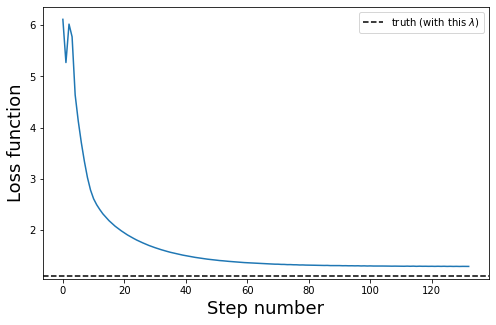

In [16]:
# Loss function
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(jnp.arange(len(loss_history)), loss_history)
ax.axhline(y=loss(source_true), ls='dashed', c='k', label='truth (with this $\lambda$)')
ax.set_ylabel("Loss function", fontsize=FS)
ax.set_xlabel("Step number", fontsize=FS)
ax.legend()
plt.show()

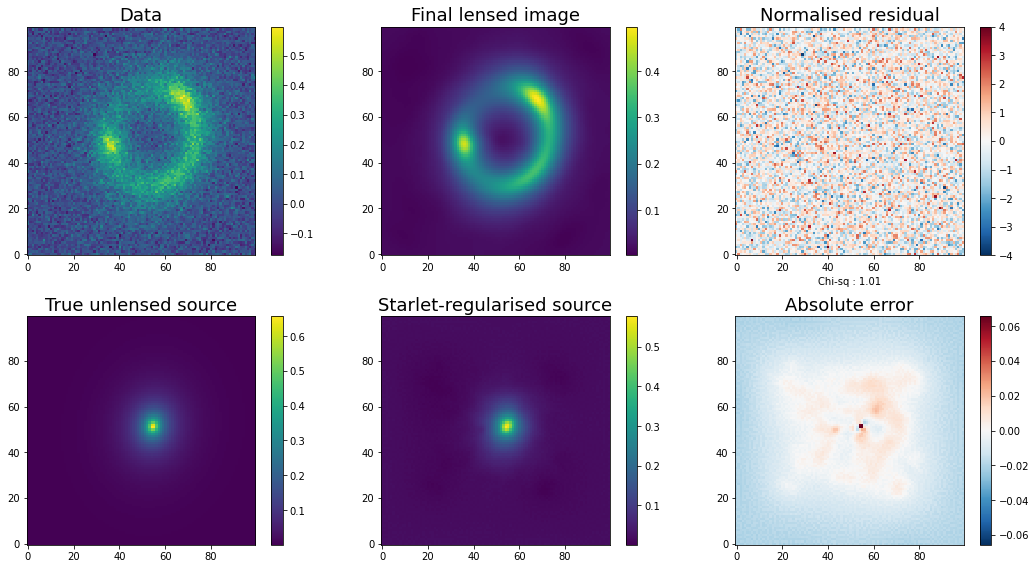

In [17]:
def plot_source_reconstruction(p_result, loss_history=None):
    s_final = p_result.reshape(*source_true.shape)
    kwargs_result = parameters.args2kwargs(p_result)

    rec_f = fit_lens_image.model(**kwargs_result)  # truth

    # Image plane reconstruction
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    ax1, ax2, ax3 = axes[0, :]
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec_f, origin='lower')
    ax2.set_title("Final lensed image", fontsize=FS)
    img3 = ax3.imshow((data - rec_f) / noise_map, origin='lower', vmin=-4, vmax=4, cmap='RdBu_r')
    ax3.set_title("Normalised residual", fontsize=FS)
    chi2 = jnp.mean((data - rec_f)**2 / fit_lens_image.Noise.C_D)
    ax3.set_xlabel(f"Chi-sq : {chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes[0, :]):
        fig.colorbar(img, ax=ax)
    #fig.tight_layout()

    # Source plane reconstruction
    #fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes[1, :]
    vmax = source_true.max()
    img1 = ax1.imshow(source_true, origin='lower') #, vmax=vmax)
    ax1.set_title("True unlensed source", fontsize=FS)
    img2 = ax2.imshow(s_final, origin='lower') #, vmax=vmax)
    ax2.set_title("Starlet-regularised source", fontsize=FS)

    img3 = ax3.imshow(source_true - s_final, origin='lower', vmin=-vmax/10., vmax=vmax/10., cmap='RdBu_r')
    ax3.set_title("Absolute error", fontsize=FS)
    for img, ax in zip((img1, img2, img3), axes[1, :]):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_source_reconstruction(p_final)

### Comparison with `optax` optimizers

In [18]:
# Create the loss function (optionally, can be different that the previous one)
grad_loss_optax = jax.jit(jax.grad(loss))

# Max number of iterations
n_iter = 100

# Global learning rate (or initial value when decaying)
learning_rate = 1e-2

#### Using a basic optimizer

Runtime: 5.08 s
Final loss: 1.14


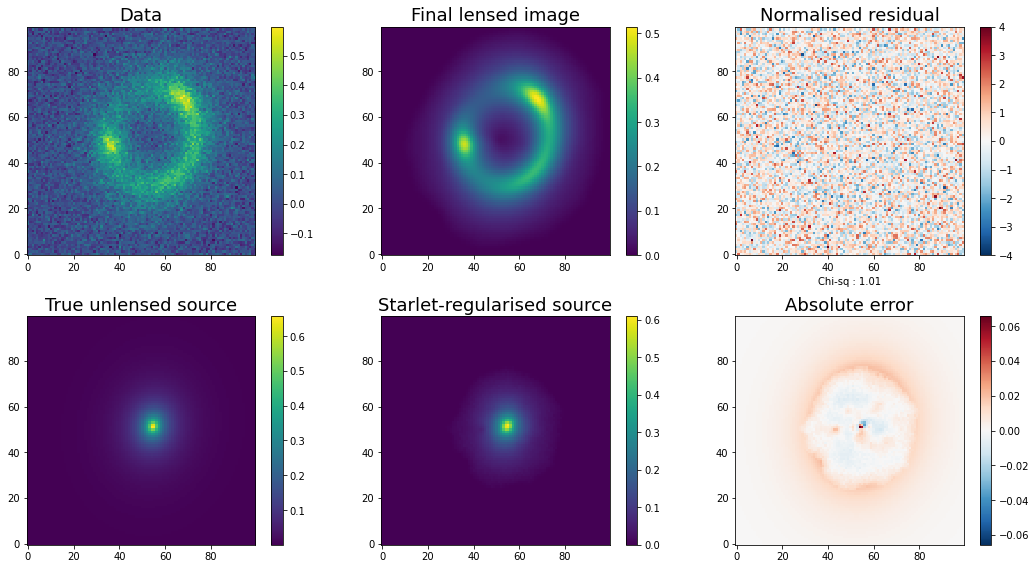

In [19]:
# Select the optimizer and global learning rate
optimizer_optax = optax.adabelief(learning_rate)

# Initialize optimizer
params = jnp.array(p_init)
opt_state = optimizer_optax.init(params)

start_time = time()

# A simple update loop.
for _ in range(n_iter):
    updates, opt_state = optimizer_optax.update(grad_loss_optax(params), opt_state, params)
    params = optax.apply_updates(params, updates)
    
    # Enforce positivity (sparsity is handled inside the loss function)
    params = positivity(params)

print(f"Runtime: {time()-start_time:0.2f} s")

p_final_optax = params
print("Final loss: {:.2f}".format(loss(p_final_optax)))

plot_source_reconstruction(p_final_optax)

#### Using a custom optimizer with learning rate decay

Runtime:  1.24 s
Final loss : 1.14


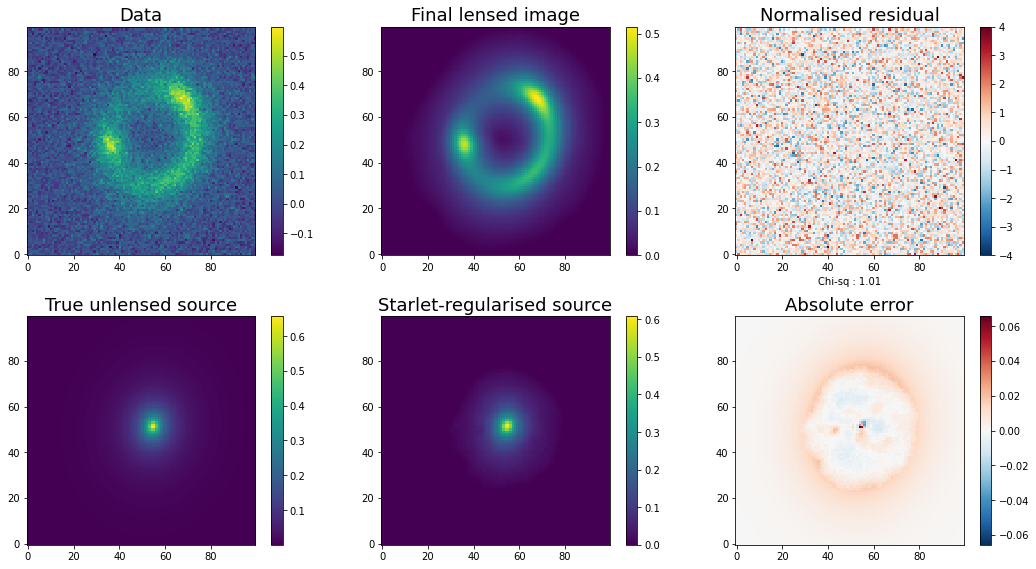

In [20]:
# Exponential decay of the learning rate
scheduler = optax.exponential_decay(
    init_value=learning_rate, 
    transition_steps=n_iter,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`
optimizer_custom = optax.chain(
    #optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm
    optax.scale_by_belief(),  # Use the updates from an optimizer
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler
    optax.scale(-1.)  # because gradient *descent*
)

params = jnp.array(p_init)
opt_state = optimizer_custom.init(params)

start_time = time()

# A simple update loop.
for _ in range(n_iter):
    updates, opt_state = optimizer_custom.update(grad_loss_optax(params), opt_state, params)
    params = optax.apply_updates(params, updates)
    
    # Enforce positivity (sparsity is handled inside the loss function)
    params = positivity(params)

print(f"Runtime: {time() - start_time : 0.2f} s")

p_final_optax2 = params
print("Final loss : {:.2f}".format(loss(p_final_optax2)))

plot_source_reconstruction(p_final_optax2)

### Comparison with `minimize` methods

__Does not work well!__ Typically takes ages...